# Compute time scales for showcase glaciers

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append('../code/')
import plots.plot_timeseries as plt_time

In [3]:
# define plot output directory
plot_dir = "/Users/oberrauch/work/master/plots/final_plots/sensitivity/"

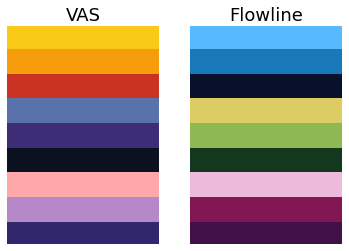

In [4]:
# get colors
from plots.master_colors import vas_cycle, fl_cycle, plot_colors
plot_colors([vas_cycle, fl_cycle], ['VAS', 'Flowline'])

## Load dataset and take first look

In [124]:
# load scaling params sensitivity results
data_dir = '/Users/oberrauch/work/master/data/'
f_name = 'cluster_output/single_glaciers/eq_runs.nc'
ds = xr.load_dataset(os.path.join(data_dir, f_name))
ds['normalized'] = ds.normalized.astype(bool)

# load showcase glaciers and limit dataset
showcase_glaciers = pd.read_csv(os.path.join(data_dir, 'showcase_glaciers.csv'), index_col=0)
ds = ds.sel(rgi_id = showcase_glaciers.index)

ds

<xarray.Dataset>
Dimensions:         (mb_model: 2, model: 2, normalized: 2, rgi_id: 6, temp_bias: 3, time: 1001)
Coordinates:
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
    calendar_year   (time) int64 -1 0 1 2 3 4 5 ... 993 994 995 996 997 998 999
    hydro_year      (time) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999 1000
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * model           (model) object 'vas' 'fl'
  * normalized      (normalized) bool False True
  * temp_bias       (temp_bias) float64 0.0 0.5 -0.5
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
  * rgi_id          (rgi_id) object 'RGI60-11.00897' ... 'RGI60-11.01238'
  * mb_model        (mb_model) object 'random' 'constant'
Data variables:
    volume          (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    area            (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    length          (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    ela             (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev86+g5d61f9d
    calendar:       365-day no leap
    creation_date:  2020-09-16 15:13:48

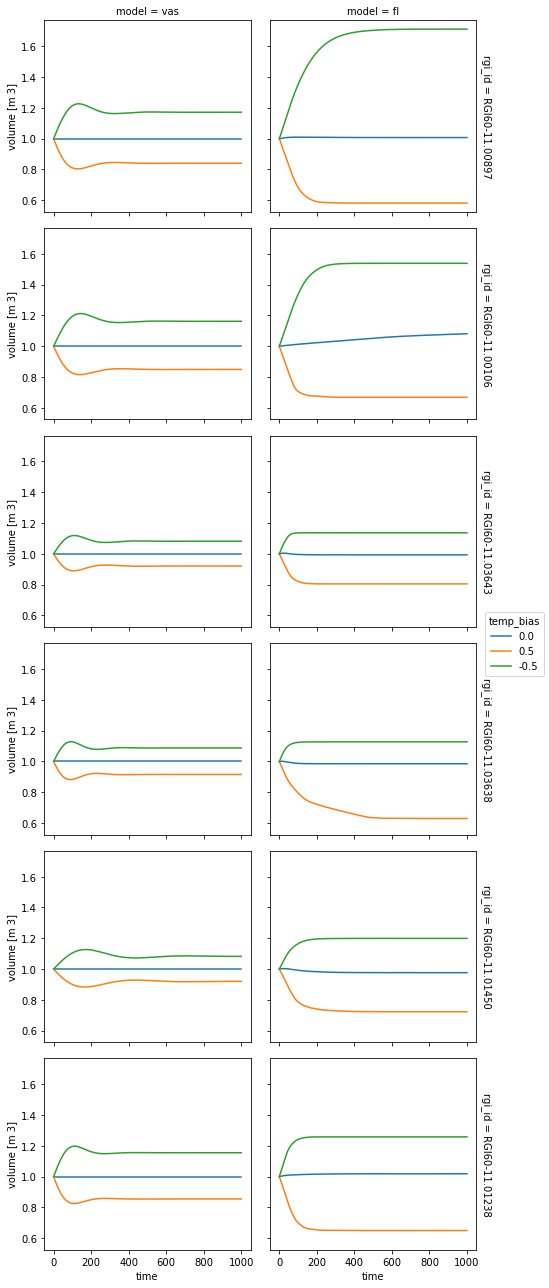

In [86]:
ds.sel(mb_model='constant', normalized=True).volume.plot.line(x='time', row='rgi_id', col='model')

The "equilibrium run" without any temperature bias is not as "flat" as expected for any glacier modeled by the flowline model. I wonder if I messed up some settings, hence I'll compare the output under random climate with the 10'000 year time series for the showcase glaciers.

In [87]:
# load scaling params sensitivity results
data_dir = '/Users/oberrauch/work/master/data/'
f_name = 'cluster_output/showcase_glaciers_random_climate/eq_runs.nc'
ds_rand = xr.load_dataset(os.path.join(data_dir, f_name))
ds_rand['normalized'] = ds_rand.normalized.astype(bool)

# load showcase glaciers and limit dataset
showcase_glaciers = pd.read_csv(os.path.join(data_dir, 'showcase_glaciers.csv'), index_col=0)
ds_rand = ds_rand.sel(rgi_id = showcase_glaciers.index)

# limit to first 1000 years
ds_rand = ds_rand.sel(time=slice(0,1000))

In [101]:
# check differences for all data variables
ds_diff = (ds_rand.sel(mb_model='random', normalized=True) - ds.sel(mb_model='random', normalized=True))
ds_diff = ds_diff.fillna(0)
for var in ds_diff.data_vars:
    print('{} equal: {}'.format(var, (ds_diff[var] == 0).all().values))

volume equal: True
area equal: True
length equal: True
ela equal: True


In [98]:
# Test entire dataset
print('Dataset equal:', ds.sel(mb_model=['random']).equals(ds_rand))

Dataset equal: True


Seems like I did't screw up, the datasets are identical... then let's look at the Pasterze (RGI60-11.00106) for which the equilibrium run seem at least in equilibrium. This is done via the `tmp_test()` function of the `eq_runs.py` module.

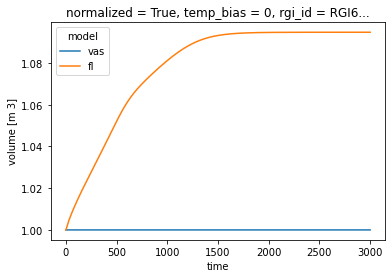

In [103]:
# load scaling params sensitivity results
data_dir = '/Users/oberrauch/work/master/data/'
f_name = 'tmp/eq_runs.nc'
ds_test = xr.load_dataset(os.path.join(data_dir, f_name))
ds_test['normalized'] = ds_test.normalized.astype(bool)
ds_test.squeeze().sel(normalized=True).volume.plot.line(x='time')

Most obviously, the flowline model glacier grows by about 9% under equilibrium conditions... and it takes more than 1'000 years. I used the values at year `t=1000` as equilibrium value, so I'll have to change that. To make sure that the others are ok, I look at the oscillation over the last 100 years of all glaciers.

**Check if in equilibrium...**

In [145]:
std

nan

In [150]:
# find combination of glacier and climate scenario
# where the final equilibrium volume (between 900 and 1000 years)
# has a standard deviation above a given threshold
threshold = 1e-5
std = ds.sel(model='fl', mb_model='constant', normalized=True).volume.isel(time=slice(900,None)).std(dim='time')
non_eq = std.where(std > threshold, drop=True)

# print
for rgi_id in non_eq.rgi_id:
    for temp_bias in non_eq.temp_bias:
        std = float(non_eq.sel(rgi_id=rgi_id, temp_bias=temp_bias).values)
        if np.isfinite(std):
            print(f'{rgi_id.values} under {temp_bias.values:+.1f}°C: std = {std*100:.2} %')

RGI60-11.00897 under -0.5°C: std = 0.003 %
RGI60-11.00106 under +0.0°C: std = 0.12 %
RGI60-11.01450 under -0.5°C: std = 0.0091 %
RGI60-11.01238 under +0.0°C: std = 0.0026 %


**Time scales**

In [11]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(scaling_params=p, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.scaling_params.values, name='scaling_params'),
                   index=variables)
tau

scaling_params,"(4.551, 0.191, 2.2, 1.375)","(1.555, 0.252, 2.2, 1.375)"
volume,36,48
area,52,54
length,80,108


**Equilibrium values**

In [7]:
# get table with final values of volume for different time scales factors
var = 'volume'
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e9, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table.sort_index()

volume                    
                                 abs                norm
scaling_params                                          
(1.555, 0.252, 2.2, 1.375)  0.662292  0.8418190437884365
(4.551, 0.191, 2.2, 1.375)  0.501925  0.8417357486017781

In [8]:
# get table with initial and final values as well as the difference between the two
var = 'area'
dec_power = 1e6

data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_eq = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=1000)[var]
        ds_init = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=0)[var]
        data.append([ds_init.values/dec_power, ds_eq.values/dec_power, ds_eq.values/dec_power - ds_init.values/dec_power])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 3),
                                                                np.tile(['init', 'eq', 'diff'], 1)))),)
table.sort_index()

volume                    
                             init        eq      diff
scaling_params                                       
(1.555, 0.252, 2.2, 1.375)  8.036  7.090138 -0.945862
(4.551, 0.191, 2.2, 1.375)  8.036  7.089598 -0.946402

**Time until equlibrium**

In [9]:
# get table with final values of volume for different time scales factors
var = 'volume'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        geom = ds.sel(scaling_params=p, normalized=False).squeeze()[var]
        geom_eq_value = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=-1)[var].mean().values
        geom_limit = geom_eq_value * 0.001
        geom_eq = geom.where(abs(geom - geom_eq_value) < geom_limit)
        yr = geom_eq.where(xr.ufuncs.isnan(geom_eq), drop=True).isel(time=-1).time.values+1
        data.append(int(yr))

table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'), columns=['time_until_eq'])
table.sort_index()    

,time_until_eq
scaling_params,
"(1.555, 0.252, 2.2, 1.375)",573
"(4.551, 0.191, 2.2, 1.375)",435


**Maximum values**

In [10]:
# get table with final values of volume for different time scales factors
var = 'area'
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze()[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs_min.values/1e6), 1-float(norm_min.values), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=['abs', 'norm', 'year'])
table.sort_index()

,abs,norm,year
scaling_params,,,
"(1.555, 0.252, 2.2, 1.375)",6.863942,0.145851,178
"(4.551, 0.191, 2.2, 1.375)",6.876083,0.144340,147


**Response times $\tau$**

In [11]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(scaling_params=p, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.scaling_params.values, name='scaling_params'),
                   index=variables)
tau

scaling_params,"(4.551, 0.191, 2.2, 1.375)","(1.555, 0.252, 2.2, 1.375)"
volume,36,48
area,52,54
length,80,108


### Sensitivity to time scale

In [36]:
# load scaling params sensitivity results
dir_path = '/Users/oberrauch/work/master/data/hef_sensitivity/'
f_name = 'time_scale_sensitivity.nc'
ds = pickle.load(open(os.path.join(dir_path, f_name), mode='rb'))

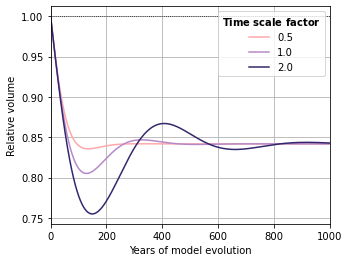

In [43]:
# define variable to be plotted
variables = ['length', 'area', 'volume']
variables = ['volume']
n = True

for var in variables:
    # call plotting function
    ds_plot = ds.sel(normalized=n).isel(scaling_params=0)
    ds_plot = ds_plot.sortby('time_scale_factor')
    labels = [f'{f:.1f}' for f in ds_plot.time_scale_factor.values]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels, color_cycle=vas_cycle[6:],
                              legend_title='$\\bf{Time\ scale\ factor}$', legend_loc=1,
                              path=os.path.join(plot_dir, 'time_scales_hef.pdf'))

**Equilibrium values**

In [14]:
# get table with final values of volume for different time scales factors
var = 'volume'
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e9, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table.sort_index()

volume                    
                        abs                norm
time_scale_factor                              
0.5                0.501928   0.841740674741567
1.0                0.501925  0.8417357486017781
2.0                0.502586  0.8428437018453954

In [15]:
# get table with final values of volume for different time scales factors
var = 'volume'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        geom = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        geom_eq_value = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=slice(800,1000))[var].mean().values
        geom_limit = geom_eq_value * 0.001
        geom_eq = geom.where(abs(geom - geom_eq_value) < geom_limit)
        yr = geom_eq.where(xr.ufuncs.isnan(geom_eq), drop=True).isel(time=-1).time.values+1
        data.append(int(yr))

table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'), columns=['time_until_eq'])
table.sort_index()    

,time_until_eq
time_scale_factor,
0.5,234
1.0,434
2.0,832


**Maximum values**

In [16]:
# get table with final values of volume for different time scales factors
var = 'volume'
dec_power = 1e9
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        abs_eq = ds_abs.isel(time=-1)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs(abs_min.values-abs_eq.values))/dec_power, float(abs(abs_min.values-abs_eq.values)/abs_eq.values*100), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=['abs', 'rel. overshoot', 'year'])
table.sort_index()

,abs,rel. overshoot,year
time_scale_factor,,,
0.5,0.003637,0.724637,135
1.0,0.021833,4.349884,129
2.0,0.052415,10.429028,150


**Response times $\tau$**

In [17]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(time_scale_factor=f, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                   index=variables)
tau

time_scale_factor,0.5,1.0,2.0
volume,39,36,34
area,47,52,63
length,66,80,102


## HISTALP Sensitivity

### Sensitivity to scaling parameters

In [18]:
# load scaling params sensitivity results
path = '/Users/oberrauch/work/master/data/scaling_params/run_output_constant_vas.nc'
ds = pickle.load(open(path, mode='rb'))

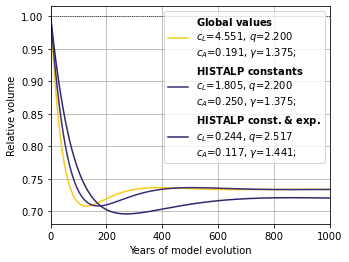

In [19]:
variables = ['volume']
path = os.path.join(plot_dir, 'scaling_params_histalp.pdf')

for var in variables:
    # call plotting function
    titles = ['Global\ values', 'HISTALP\ constants', 'HISTALP\ const. &\  exp.']
    ds_plot = ds.sel(normalized=True, time_scale_factor=1)
    labels = [f'$\\bf{{{t}}}$\n$c_L$={c_l:.3f}, $q$={q:.3f}\n$c_A$={c_a:.3f}, $\gamma$={gamma:.3f};'
              for t, (c_l, c_a, q, gamma) in zip(titles, ds_plot.scaling_params.values)]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels, color_cycle=vas_cycle[[0,4,8]],
                              legend_loc=1,
                              path=path)

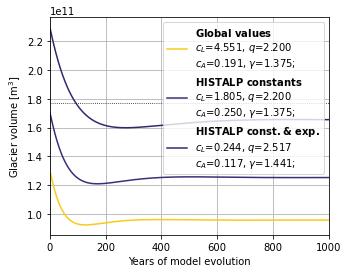

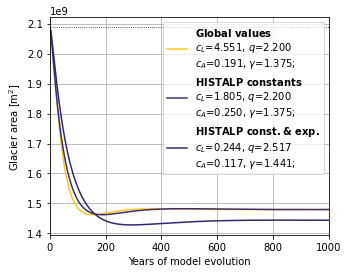

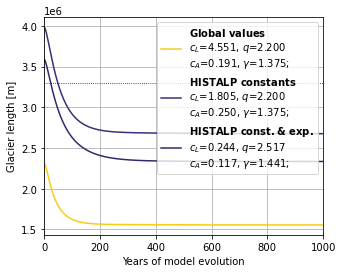

In [20]:
variables = ['volume', 'area', 'length']
path = False

for var in variables:
    # call plotting function
    titles = ['Global\ values', 'HISTALP\ constants', 'HISTALP\ const. &\  exp.']
    ds_plot = ds.sel(normalized=False, time_scale_factor=1)
    labels = [f'$\\bf{{{t}}}$\n$c_L$={c_l:.3f}, $q$={q:.3f}\n$c_A$={c_a:.3f}, $\gamma$={gamma:.3f};'
              for t, (c_l, c_a, q, gamma) in zip(titles, ds_plot.scaling_params.values)]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels, color_cycle=vas_cycle[[0,4,8]],
                              legend_loc=1, path=path)

**Equilibrium values**

In [21]:
# get table with final values of volume for different time scales factors
var = 'volume'
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e9, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table

volume                    
                                     abs                norm
scaling_params                                              
(4.551, 0.191, 2.2, 1.375)     95.759663   0.733828671847779
(1.805, 0.25, 2.2, 1.375)     125.305041  0.7336247418909089
(0.244, 0.117, 2.517, 1.441)  165.517544  0.7204630505698235

In [22]:
# get table with initial and final values as well as the difference between the two
var = 'volume'
n = True
dec_power = 1e0


data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_eq = ds.sel(scaling_params=p, normalized=n).squeeze().isel(time=1000)[var]
        ds_init = ds.sel(scaling_params=p, normalized=n).squeeze().isel(time=0)[var]
        data.append([ds_init.values/dec_power, ds_eq.values/dec_power, ds_eq.values/dec_power - ds_init.values/dec_power])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 3),
                                                                np.tile(['init', 'eq', 'diff'], 1)))),)
table

volume                    
                               init        eq      diff
scaling_params                                         
(4.551, 0.191, 2.2, 1.375)      1.0  0.733829 -0.266171
(1.805, 0.25, 2.2, 1.375)       1.0  0.733625 -0.266375
(0.244, 0.117, 2.517, 1.441)    1.0  0.720463 -0.279537

**Maximum values**

In [23]:
# get table with final values of volume for different time scales factors
var = 'volume'
dec_power = 1e9
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze()[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs(abs_min.values-abs_eq.values))/dec_power, float(abs(abs_min.values-abs_eq.values)/abs_eq.values*100), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=['abs', 'rel. overshoot', 'year'])
table.sort_index()

,abs,rel. overshoot,year
scaling_params,,,
"(0.244, 0.117, 2.517, 1.441)",159.400182,31716.006572,272
"(1.805, 0.25, 2.2, 1.375)",120.459142,23967.870557,171
"(4.551, 0.191, 2.2, 1.375)",91.882396,18281.928092,128


**Response times $\tau$**

In [24]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(scaling_params=p, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.scaling_params.values, name='scaling_params'),
                   index=variables)
tau

scaling_params,"(4.551, 0.191, 2.2, 1.375)","(1.805, 0.25, 2.2, 1.375)","(0.244, 0.117, 2.517, 1.441)"
volume,31,42,61
area,41,45,62
length,44,63,71


### Sensitivity to time scale

In [25]:
# load time scale sensitivity results
path = '/Users/oberrauch/work/master/data/timescale_sensitivity/time_scale_sensitivity.nc'
ds = pickle.load(open(path, mode='rb'))

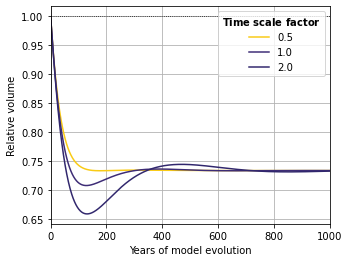

In [26]:
# call plotting function
ds_plot = ds.sel(normalized=True).isel(scaling_params=0)
ds_plot = ds_plot.sortby('time_scale_factor')
labels = [f'{f:.1f}' for f in ds_plot.time_scale_factor.values]
plt_time.plot_time_series(ds_plot, var='volume', labels=labels, color_cycle=vas_cycle[[0,4,8]],
                          legend_title='$\\bf{Time\ scale\ factor}$', legend_loc=1,
                          path=os.path.join(plot_dir, 'time_scales_histalp.pdf'))

**Equilibrium values**

In [27]:
# get table with final values of volume for different time scales factors
var = 'volume'
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e9, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table.sort_index()

volume                    
                         abs                norm
time_scale_factor                               
0.5                95.754236  0.7337870855836647
1.0                95.759663   0.733828671847779
2.0                95.632304  0.7328526876822211

In [28]:
# get table with final values of volume for different time scales factors
var = 'volume'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        geom = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        geom_eq_value = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=-1)[var].mean().values
        geom_limit = geom_eq_value * 0.001
        geom_eq = geom.where(abs(geom - geom_eq_value) < geom_limit)
        yr = geom_eq.where(xr.ufuncs.isnan(geom_eq), drop=True).isel(time=-1).time.values+1
        data.append(int(yr))

table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'), columns=['time_until_eq'])
table.sort_index()    

,time_until_eq
time_scale_factor,
0.5,312
1.0,515
2.0,941


**Maximum values**

In [29]:
# get table with final values of volume for different time scales factors
var = 'volume'
dec_power = 1e9
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs(abs_min.values-abs_eq.values))/dec_power, float(abs(abs_min.values-abs_eq.values)/abs_eq.values*100), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=['abs', 'rel. overshoot', 'year'])
table.sort_index()

,abs,rel. overshoot,year
time_scale_factor,,,
0.5,95.211586,18944.340343,177
1.0,91.882396,18281.928092,128
2.0,85.493580,17010.739253,131


**Response times $\tau$**

In [30]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(time_scale_factor=f, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                   index=variables)
tau

time_scale_factor,1.0,0.5,2.0
volume,31,35,29
area,41,39,45
length,44,43,45


## Test

### Sensitivity to time scale

In [31]:
dir_path = '/Users/oberrauch/work/master/data/'
# load time scale sensitivity results
f_name = 'timescale_sensitivity/run_output_constant_vas.nc'
ds_ts = pickle.load(open(os.path.join(dir_path, f_name), mode='rb'))
# load scaling params sensitivity results
f_name = 'scaling_params/run_output_constant_vas.nc'
ds_sc = pickle.load(open(os.path.join(dir_path, f_name), mode='rb'))

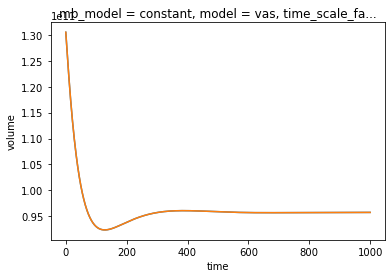

In [32]:
ds_sc.sel(scaling_params=ds_ts.scaling_params, normalized=False).volume.plot()
ds_ts.sel(time_scale_factor=ds_sc.time_scale_factor, normalized=False).volume.plot()

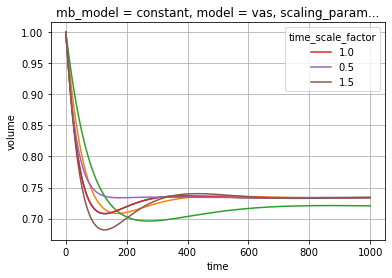

In [33]:
ds_sc.sel(normalized=True).squeeze().volume.plot.line(x='time')
ds_ts.sel(normalized=True).squeeze().volume.plot.line(x='time')
plt.grid()

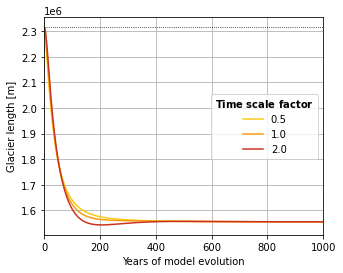

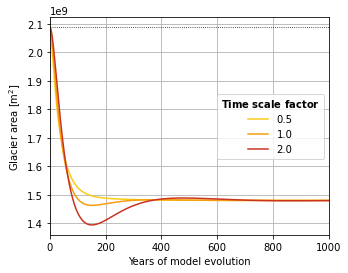

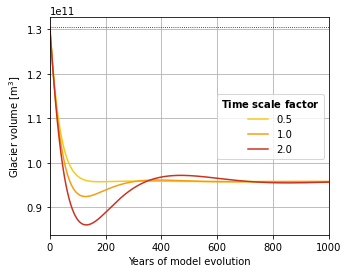

In [34]:
# define variable to be plotted
variables = ['length', 'area', 'volume']
n = False

for var in variables:
    # call plotting function
    ds_plot = ds.sel(normalized=n).isel(scaling_params=0)
    ds_plot = ds_plot.sortby('time_scale_factor')
    labels = [f'{f:.1f}' for f in ds_plot.time_scale_factor.values]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels,
                              color_cycle=vas_cycle, legend_title='$\\bf{Time\ scale\ factor}$')

In [35]:
time_scale_factor

NameError: name 'time_scale_factor' is not defined